In [5]:
import time
import itertools
import numpy as np
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
from tqdm import tqdm
from multiprocessing import Pool

from simulation import simulation
from simulation_plots import *
np.seterr(all='raise')  


{'divide': 'raise', 'over': 'raise', 'under': 'raise', 'invalid': 'raise'}

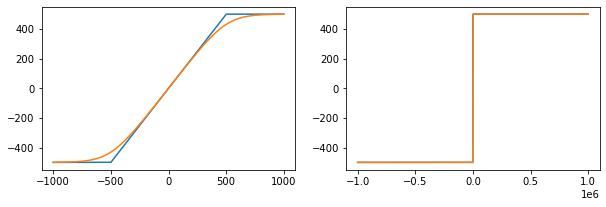

In [14]:
def smooth_clip(x, a=-500, b=500, c=0.01):
    results = []
    for xi in x:
        try:
            results.append(xi - 1/c * np.log(1 + np.exp(c * (xi - b))) + 1/c * np.log(1 + np.exp(-c* (xi - a))))
        except:
            if xi > b:
                results.append(b)
            if xi < a:
                results.append(a)
    return np.array(results)

    
fig, axs = plt.subplots(1, 2, figsize = (10, 3))

x = np.linspace(-1000, 1000, num=100000)
axs[0].plot(x, np.clip(x, -500, 500))
axs[0].plot(x, smooth_clip(x, -500, 500, 0.01))

x = np.array(np.linspace(-1000000, 1000000, num=1000000))
axs[1].plot(x, np.clip(x, -500, 500))
axs[1].plot(x, smooth_clip(x, -500, 500, 0.01))

plt.show()

In [15]:
def objective_function(beta, X, y, rewards, propensity_scores, l = 0.1, S = 1, use_smooth_clip = False, 
                       correct_min_count = None, miss_min = None, intercept = False, pelnalty_norm = False):
#     clip_func = smooth_clip if use_smooth_clip else lambda x: np.clip(x, -500, 500)

    clip_func = smooth_clip if use_smooth_clip else lambda x: x
    all_loss = 0
    for pid, covariates in X.items():
        assignments = np.array(y[pid])
        reward = rewards[pid]
        if intercept:
            func_outputs =  np.array([np.matmul(beta, np.hstack([1, var])) for var in covariates]) 
        else:
            func_outputs =  np.array([np.matmul(beta, var) for var in covariates])
                    
        pscore = propensity_scores[pid]
        asy_min = -np.log(np.sum(np.exp(clip_func(-func_outputs * assignments) * S))) / S
        pid_loss = -(reward * -np.log(1 + np.exp(clip_func(-np.array([asy_min])))) / pscore)
        all_loss = pid_loss + all_loss
        
        if correct_min_count is not None and miss_min is not None:
            if np.all(np.abs(func_outputs * assignments - asy_min) >= np.abs(min(func_outputs * assignments) - asy_min)):
                correct_min_count[1] += 1
            miss_min.append(func_outputs * assignments)
            correct_min_count[0] += 1

    if pelnalty_norm:
        all_loss = 1 / len(X) * all_loss + l * (np.sum(beta**2) - 1)
    else:
        all_loss = 1 / len(X) * all_loss + l * np.sum(beta**2)
    return all_loss

In [16]:
optimal_decision_rule = lambda x, pid=None, idx=None: 0.5 + 0.4 * x[0] - 0.32 * x[1] - 0.71 * x[2]
Q0 = lambda x, o, a: 1 + 2 * x[0] + x[1] + 0.5 * x[2] + o*a
VF = lambda x_dict, x_dict_scaled, assignment_rule: \
    np.mean([np.sum([Q0(x_dict[pid][idx], 
                        np.sign(optimal_decision_rule(x_dict[pid][idx])), 
                        np.sign(assignment_rule(x_dict_scaled[pid][idx], pid, idx)))
                     for idx in range(x_dict[pid].shape[0])]) for pid in x_dict])

optimal_betas = np.array([0.4, -0.32, -0.71])

x0 = np.array(optimal_betas) + np.random.normal(0, 0.05, 3)
print('Optimal Betas:  ', optimal_betas)
print("Initialized x0:   ", x0)
##########

Optimal Betas:   [ 0.4  -0.32 -0.71]
Initialized x0:    [ 0.4555312 -0.3401674 -0.6120413]


### Uniform Distribution

In [19]:
def x_distr(*x, size=1):
    return np.random.uniform(*x, size=size)

#### Unif(-1, 1)

In [23]:
sim = simulation(optimal_decision_rule, Q0, VF, objective_function, x_distr, balanced = True, n=1000)
sim.generate_data(-1, 1)

In [25]:
import torch
from torch import optim
from torch.autograd import Variable 

ModuleNotFoundError: No module named 'torch'

In [17]:
X = Variable(torch.tensor(np.array(list(sim.X_dict.values()))), requires_grad=False)
assignments = Variable(torch.tensor(list(sim.y_dict.values())), requires_grad = False)
rewards = Variable(torch.tensor(list(sim.total_rewards_dict.values())), requires_grad = False)

beta = Variable(torch.tensor([0.4, -0.32, -0.71]).type(torch.FloatTensor), requires_grad = True)
beta.shape

S = 0.1
learning_rate = 1e-04
optimizer = torch.optim.Adam([beta], lr=learning_rate)
for t in range(500):
    func_outputs = X.view(-1, 3).mv(beta.double()).view(-1, 4)
    func_assign = torch.cat([i * z for i, z in zip(func_outputs, assignments)]).view(-1, 4)
    asy_min = -torch.log(torch.sum(torch.exp(-func_assign * S), axis = 1)) / S
    loss = torch.sum(-(rewards * -torch.log(1 + torch.exp(-asy_min))))
    print(t, loss.data.item())
    
    loss.backward()
    optimizer.step()
    
    beta.data -= learning_rate * beta.grad.data
    beta.grad.data.zero_()
    optimizer.zero_grad()

NameError: name 'Variable' is not defined